In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Path to train and test data
train_path = '/content/drive/MyDrive/Cropped_Final/Train'
test_path = '/content/drive/MyDrive/Cropped_Final/Test'

# Initialize data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(524, 524),
    color_mode="grayscale",
    batch_size=32,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(524, 524),
    color_mode="grayscale",
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1080 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

# Define the model (assuming you've already done this)
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(48, (11, 11), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.4)(x)
    x = Conv2D(96, (5, 5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model with the specified input shape
model = create_model((524, 524, 1))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)

# List of callbacks
callbacks_list = [early_stop, reduce_lr]

# Train the model
epochs = 50
batch_size = 32

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks_list,
    batch_size=batch_size
)

Epoch 1/50
34/34 [==============================] - 18s 451ms/step - loss: 80.2615 - accuracy: 0.6648 - val_loss: 37.2128 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 15s 438ms/step - loss: 8.5217 - accuracy: 0.8343 - val_loss: 17.8103 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 14s 413ms/step - loss: 2.4160 - accuracy: 0.9111 - val_loss: 60.9296 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 14s 417ms/step - loss: 1.2361 - accuracy: 0.9426 - val_loss: 89.8897 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 14s 412ms/step - loss: 0.5580 - accuracy: 0.9648 - val_loss: 108.4494 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 14s 412ms/step - loss: 0.5297 - accuracy: 0.9630 - val_loss: 114.3212 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - ETA

In [ ]:

# Predict class labels for the test dataset
predictions = model.predict(test_generator)
y_pred = np.round(predictions).astype(int).flatten()

# Get the true class labels
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")

#P.s here i am using "restore_best_weights=True" hence weights from epoch 2 were restored because they provided the best validation performance according to the early stopping criteria.

2/2 [==============================] - 1s 356ms/step
Accuracy: 0.7333


In [ ]:

# Predict class labels for the test dataset
predictions = model.predict(test_generator)
y_pred = np.round(predictions).astype(int).flatten()

# Get the true class labels
y_true = test_generator.classes

# Calculate F1-score, Recall, and Precision
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

2/2 [==============================] - 1s 338ms/step
Precision: 0.7431
Recall: 0.7333
F1-score: 0.7306


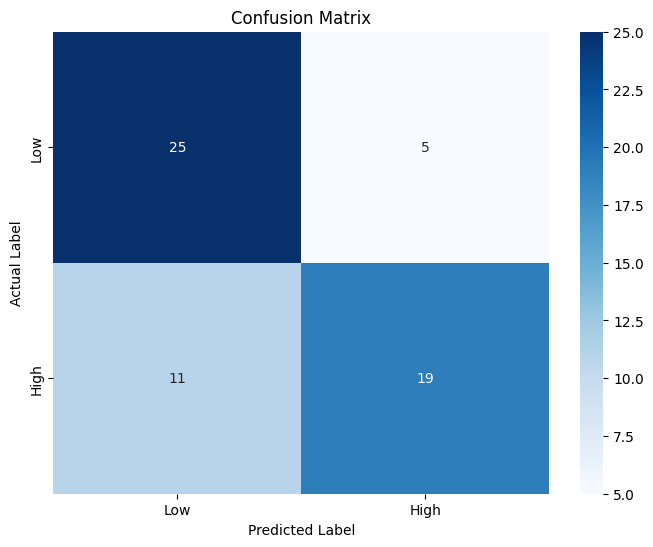

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Low', 'High'],
            yticklabels=['Low', 'High'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

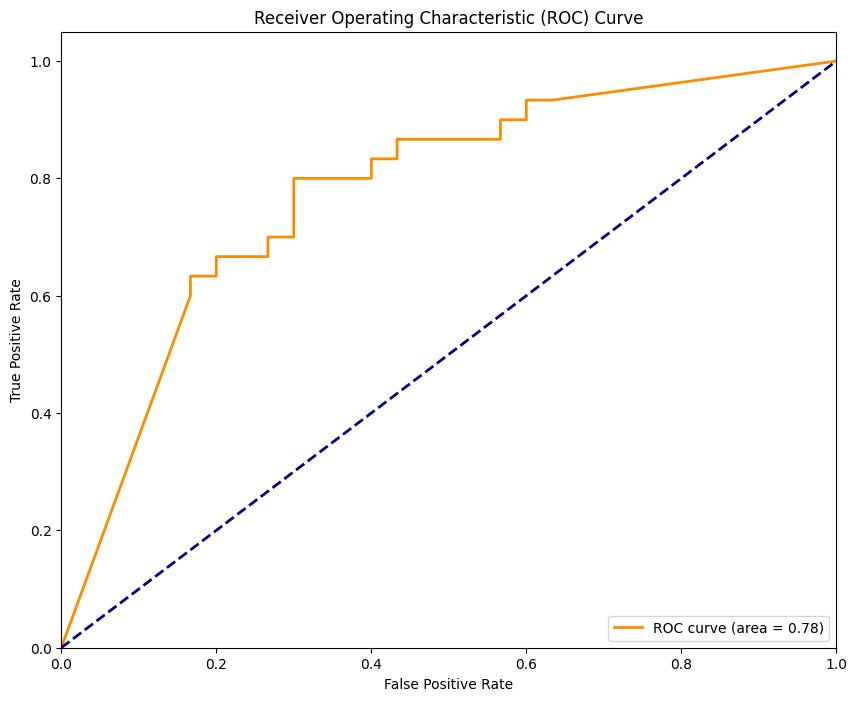

In [ ]:

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, predictions)  # predictions are the probabilities obtained from model.predict
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()